# Imports

In [1]:
import tensorflow as tf
import zfit
from zfit import z
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

2022-04-13 11:02:05.585104: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-13 11:02:05.585149: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/__init__.py:37: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."


# Load Data

In [33]:
useNormalisation = False
if useNormalisation:
    v = "8.0.1"
else:
    v = "9.0.1"

pre = pd.read_csv(f'../data_files/{v}/all.csv', index_col=[0])
pre = pre['Lb_M'][pre['category']==1].to_numpy()
pre = pre[np.logical_and(pre < 6500, pre > 4500)]

# Plot Distributions

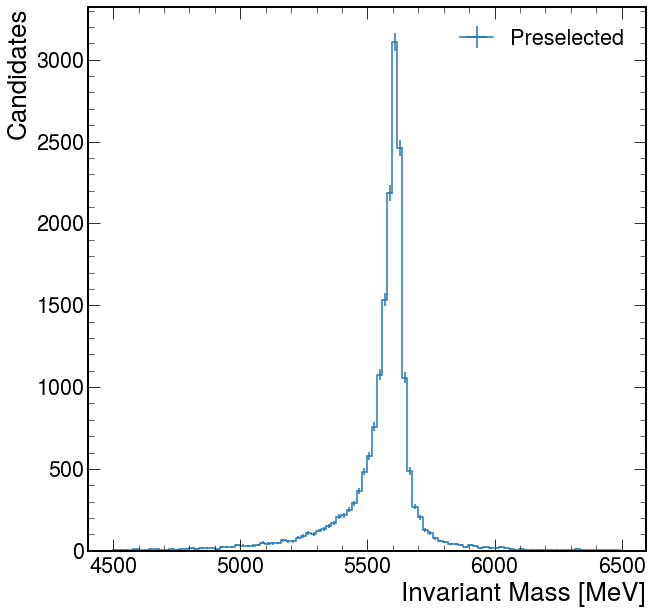

In [34]:
fpre, bins = np.histogram(pre, bins=100)

fig, ax = plt.subplots(1, 1)
hep.histplot(fpre, yerr=True, bins=bins, ax=ax, label='Preselected')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Candidates')
plt.legend()
plt.show()

In [35]:
def fitDoubleCB(np_data, label, mass_ranges=[4000, 6500], param_ranges=[[5600, 5500, 5700],[20, 10, 50],[1, 0, 2],[4, 0.1, 10],[1, 0, 2],[4, 0.1, 10],[30000, 0, 100000]]):
    massObsMC = zfit.Space("Lb_M", limits=(mass_ranges[0], mass_ranges[1]))
    MC_LbM = zfit.Data.from_numpy(obs=massObsMC, array=np_data)
    
    mu_CB = zfit.Parameter('mu_CB_%s'%label, *param_ranges[0])
    sigma_CB = zfit.Parameter('sigma_CB_%s'%label, *param_ranges[1])
    alpha_l = zfit.Parameter('alpha_l_%s'%label, *param_ranges[2])
    n_l = zfit.Parameter('n_l_%s'%label, *param_ranges[3])
    alpha_r = zfit.Parameter('alpha_r_%s'%label, *param_ranges[4])
    n_r = zfit.Parameter('n_r_%s'%label, *param_ranges[5])
    
    dcb = zfit.pdf.DoubleCB(obs=massObsMC, mu=mu_CB, sigma=sigma_CB, alphal=alpha_l, nl=n_l, alphar=alpha_r, nr=n_r)
    
    dcb_yield = zfit.Parameter('DCB_yield_%s'%label, *param_ranges[6], step_size=1)
    dcb_ext = dcb.create_extended(dcb_yield)
    nll_ext_dcb = zfit.loss.ExtendedUnbinnedNLL(dcb_ext, MC_LbM)
    minimizerDCB = zfit.minimize.Minuit(use_minuit_grad=True)
    fitResult = minimizerDCB.minimize(nll_ext_dcb)
    
    return dcb_ext, fitResult, MC_LbM

In [42]:
pmodel, presult, pmasses = fitDoubleCB(pre, "preX", mass_ranges=[4500, 6500])

In [43]:
print(f"\nPreselection\n============\nResult Converged: {presult.converged}\nResult Valid: {presult.valid}")


Preselection
Result Converged: True
Result Valid: True


In [44]:
p_param_errors = presult.errors()
print(presult.params)

/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/minimizers/fitresult.py:1115: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


name              value         minuit_minos    at limit
--------------  -------  -------------------  ----------
DCB_yield_preX    18130  -1.3e+02   +1.4e+02       False
alpha_l_preX     0.5261  -  0.024   +  0.023       False
alpha_r_preX      1.248  -  0.045   +  0.044       False
mu_CB_preX         5611  -   0.61   +   0.64       False
n_l_preX          2.474  -  0.065   +  0.068       False
n_r_preX          1.891  -  0.064   +  0.066       False
sigma_CB_preX     22.75  -   0.89   +   0.85       False


In [45]:
for key, value in presult.params.items():
    print(f"{key.name} = {value['value']}+-({value['minuit_minos']['upper']},{value['minuit_minos']['lower']})")

DCB_yield_preX = 18125.522303153528+-(135.45203547057375,-133.82990223986153)
alpha_l_preX = 0.5260981767563985+-(0.022947987746675766,-0.02356425127791632)
alpha_r_preX = 1.248263932863779+-(0.04411139078966418,-0.04472773584389512)
mu_CB_preX = 5610.988110807817+-(0.6401982254137474,-0.6127912782973229)
n_l_preX = 2.4740996212362285+-(0.06824462909833315,-0.0653831670954099)
n_r_preX = 1.890958322009193+-(0.0659382357961897,-0.06430006866875963)
sigma_CB_preX = 22.750090579966663+-(0.8503119295375394,-0.8881764486993088)


Chi2 = 1.6


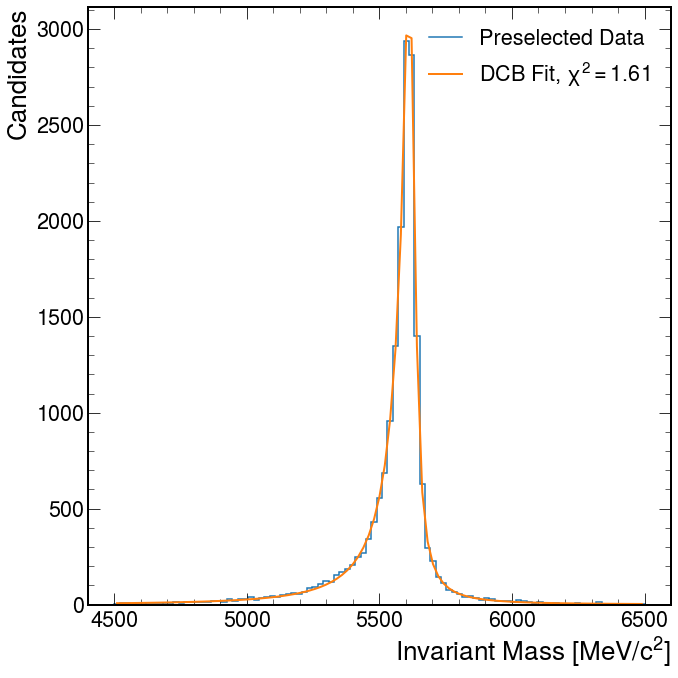

In [47]:
fig, ax = plt.subplots(1, 1)
labels = ['Preselected Data', 'No Preselection']
i = 0

for model, data in zip([pmodel], [pmasses]):
    allLimits = [data.data_range.limit1d[0], data.data_range.limit1d[1]]
    allLimits = np.array(allLimits)

    xBins = np.linspace(np.amin(allLimits), np.amax(allLimits), num=100) 
    x = (xBins[1:]+xBins[:-1])/2
    y = np.array([])
    nBinsLimit=0
    for a in range(int(allLimits.shape[0]/2)):
        nBinsLimit += len(x[(x>allLimits[a*2])&(x<allLimits[a*2+1])])
    
    y = np.append(y, model.pdf(x) * data.nevents.numpy() / nBinsLimit * np.sum(allLimits[1::2]-allLimits[::2]))

    data_plot = zfit.run(z.unstack_x(data))

    h, _ = np.histogram(data_plot, bins=xBins)
    hep.histplot(h, bins=xBins, ax=ax, label=labels[i])
    
    scaledDiff=(h[h!=0]-y[h!=0])/np.sqrt(h[h!=0])
    print("Chi2 = %.2g"%(np.sum(scaledDiff**2)/(len(scaledDiff)-len(pmodel.get_params()))))
    
    ax.plot(x, y, linewidth=2, label=r'DCB Fit, $\chi^2=1.61$')

    
    i += 1
    
plt.ylabel('Candidates')
plt.xlabel(r'Invariant Mass [$MeV/c^2$]')
plt.legend()
plt.tight_layout()
plt.savefig('../images/signalfits/Unbinned_DCB_Preselected_Rare.png')
plt.show()

# Normalisation Mode
## Load Data

In [45]:
pre = pd.read_csv('../data_files/8.0.0/all.csv', index_col=[0])
pre = pre[pre['QSQR'].between(3000, 3718)]
pre = pre['Lb_M'][pre['category']==1].to_numpy()
# Remember that Dan has already applied the pre-selection
pre = pre[np.logical_and(pre < 5800, pre > 5200)]

## Plot Data

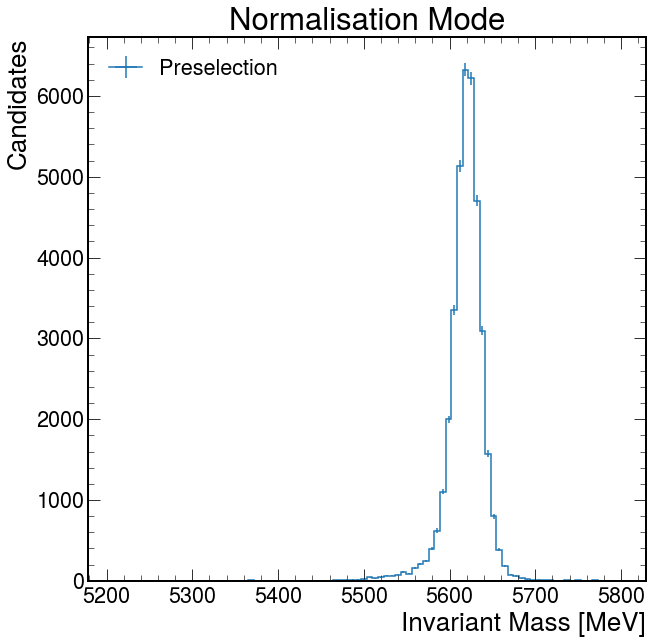

In [46]:
fpre, bins = np.histogram(pre, bins=90)
fig, ax = plt.subplots(1, 1)
hep.histplot(fpre, yerr=True, bins=bins, ax=ax, label='Preselection')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Candidates')
plt.legend()
plt.title('Normalisation Mode')
plt.show()

# Fit Data

In [49]:
model, result, space = fitDoubleCB(pre, 'Norm2', mass_ranges=[5200, 5800])

print(f"\nPreselection\n============\nResult Converged: {result.converged}\nResult Valid: {result.valid}")


Preselection
Result Converged: True
Result Valid: True


In [50]:
param_errors = result.errors()

print(result.params)

/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/minimizers/fitresult.py:1115: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


name               value         minuit_minos    at limit
---------------  -------  -------------------  ----------
DCB_yield_Norm2    37370  -1.9e+02   +1.9e+02       False
alpha_l_Norm2      1.402  -  0.026   +  0.027       False
alpha_r_Norm2      1.872  -   0.06   +  0.062       False
mu_CB_Norm2         5621  -  0.098   +  0.097       False
n_l_Norm2          3.717  -   0.15   +   0.15       False
n_r_Norm2          5.153  -   0.56   +   0.65       False
sigma_CB_Norm2     14.18  -   0.11   +   0.11       False


Chi2 = 2.70139


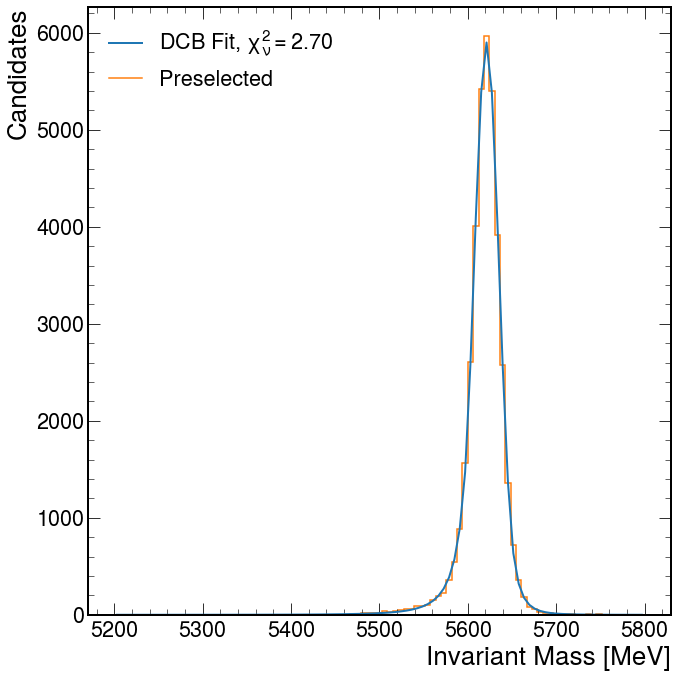

In [53]:
fig, ax = plt.subplots(1, 1)
labels = ['Preselected', 'No Preselection']
i = 0

for model, data in zip([model], [space]):
    allLimits = [data.data_range.limit1d[0], data.data_range.limit1d[1]]
    allLimits = np.array(allLimits)

    xBins = np.linspace(np.amin(allLimits), np.amax(allLimits), num=100) 
    x = (xBins[1:]+xBins[:-1])/2
    y = np.array([])
    nBinsLimit=0
    for a in range(int(allLimits.shape[0]/2)):
        nBinsLimit += len(x[(x>allLimits[a*2])&(x<allLimits[a*2+1])])
    
    y = np.append(y, model.pdf(x) * data.nevents.numpy() / nBinsLimit * np.sum(allLimits[1::2]-allLimits[::2]))

    ax.plot(x, y, linewidth=2, label=r'DCB Fit, $\chi^2_{\nu}=2.70$')
    data_plot = zfit.run(z.unstack_x(data))

    h, _ = np.histogram(data_plot, bins=xBins)
    hep.histplot(h, bins=xBins, ax=ax, label=labels[i])

    scaledDiff=(h[h!=0]-y[h!=0])/np.sqrt(h[h!=0])
    print("Chi2 = %.6g"%(np.sum(scaledDiff**2)/(len(scaledDiff)-len(model.get_params()))))
    i += 1
    
plt.ylabel('Candidates')
plt.xlabel('Invariant Mass [MeV]')
plt.legend()
plt.tight_layout()
plt.savefig('../images/signalfits/Unbinned_DCB_Preselected_Norm.png')
plt.show()